In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys

sys.path.insert(0, "../../src")

import matplotlib.pyplot as plt
import numpy as np
import torch
import h5py

from juart.dl.model.dc import DataConsistency
from juart.conopt.tfs.fourier import nonuniform_transfer_function
from juart.conopt.functional.fourier import nonuniform_fourier_transform_adjoint
from juart.vis.interactive import InteractiveFigure3D
from juart.dl.model.resnet import ResNet

In [2]:
data_path = "3DLiss_vd_preproc.h5"
with h5py.File(data_path, "r") as f:
    print(f"Dataset holds following data: {f.keys()}")

    print(f"Coilsensitivity info: {f['coilsens'].attrs['info']}")
    print(f"Trajectory info: {f['k'].attrs['info']}")
    print(f"Signal info: {f['d'].attrs['info']}")

    shape = (156,156,156,2)
    ktraj = torch.from_numpy(f['k'][:])
    coilsens = torch.from_numpy(f['coilsens'][:])
    d = torch.from_numpy(f['d'][:])

    print(f"Coilsensitivity shape {coilsens.shape}")
    print(f"Trajectory shape {ktraj.shape}")
    print(f"Signal shape {d.shape}")
    

Dataset holds following data: <KeysViewHDF5 ['coilsens', 'd', 'k']>
Coilsensitivity info: Shape (Channels, Nx, Ny, Nz).
Trajectory info: Shape (Dimensions, Samples, Echotimes). Scaled in units of cycle/fov
Signal info: Shape (Channels, Samples, Echotimes).
Coilsensitivity shape torch.Size([8, 156, 156, 156])
Trajectory shape torch.Size([3, 2001191, 2])
Signal shape torch.Size([8, 2001191, 2])


In [3]:
k_scaled = ktraj / (2*ktraj.max())

In [4]:
AHd = nonuniform_fourier_transform_adjoint(k_scaled,d,(156,156,156))
AHd = torch.sum(torch.conj(coilsens[...,None]) * AHd, dim=0)

In [5]:
AHd_unsqueeze = AHd.unsqueeze(-1)
k = k_scaled.unsqueeze(-1)

In [6]:
data = {"images_regridded" : AHd_unsqueeze,
        "kspace_trajectory" : k,
        "sensitivity_maps" : coilsens}

In [7]:
dc_block = DataConsistency(
    shape,
    axes = (1,2,3),
    device="cpu",
    verbose = True,
    niter = 1
)

In [8]:
dc_block.init(
    data["images_regridded"],
    data["kspace_trajectory"],
    sensitivity_maps=data["sensitivity_maps"],
)

In [9]:
with torch.no_grad():
    cg_sense = dc_block(data["images_regridded"])

[CG] Iter: 0 Res: 4.86E+02 : 100%|██████████| 1/1 [00:09<00:00,  9.72s/it]


In [10]:
resnet_image = torch.squeeze(cg_sense,dim=(3,4))
resnet_image_unsqueezed = resnet_image.unsqueeze(-1)
cg_image = resnet_image.abs()

interactive(children=(IntSlider(value=78, description='Dimension 3', max=156, min=1), Output()), _dom_classes=…

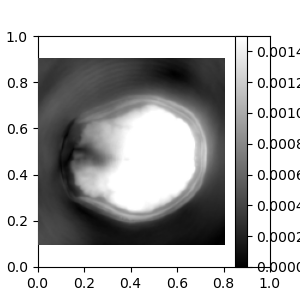

In [11]:
InteractiveFigure3D(
    torch.abs(cg_image[..., 0]).numpy(),
    vmin=0,
    vmax=0.0015,
    cmap="gray",
).interactive

In [16]:
resnet = ResNet(contrasts=2, dim=3,num_of_resblocks = 5)
image = resnet(resnet_image_unsqueezed)
plt.figure(2)
plt.imshow(np.abs((image[:, :, 80, 0]).detach()), cmap="gray", vmax=image[:,:,80,0].abs().max())

Layer1
Layer2
Layer 0 done
Layer 1 done
Layer 2 done
Layer 3 done
Layer 4 done
Layer3
Last Layer


/tmp/ipykernel_851/712029091.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs((image[:, :, 80, 0]).detach()), cmap="gray", vmax=image[:,:,80,0].abs().max())


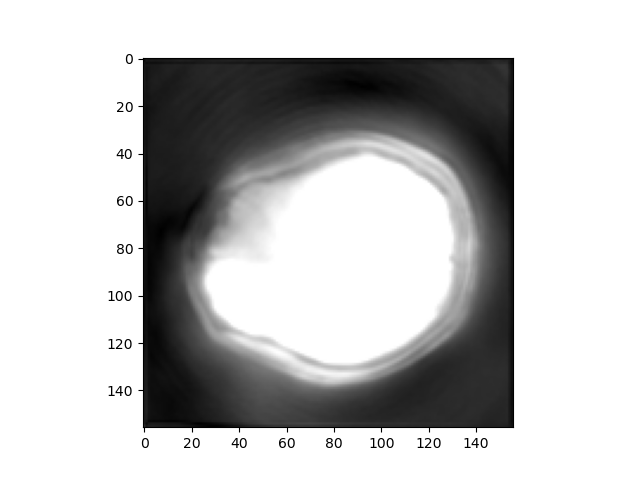

In [14]:
plt.show()